In [1]:
# Import packages
import numpy as np
import cvxpy as cp
import mosek
import time

import phi_divergence as phi
import robust_sampling as rs
import dataio
import util

The toy model we examine is as follows:

\begin{align}\label{toy_model_2}
    \begin{split}
        \max_{\mathbf{x} \geq \mathbf{0}}\{\mathbf{e}^T \mathbf{x}: \mathbb{P}^*(\mathbf{\xi}\in [-1,1]^{k}: \mathbf{\xi}^T \mathbf{x} \leq 1)\geq \beta\}.
    \end{split}
\end{align}

In [2]:
# Problem specific functions:
def generate_data(random_seed, k, N):
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N,k)) # generates N random scenarios    
    return data 

def generate_data_with_nominal(random_seed, k, N):
    data_nominal = np.array([[0] * k])
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N-1,k)) # generate N-1 scenarios
    data = np.concatenate((data_nominal,data)) # add nominal case to training data
    return data

def solve_SCP(S, time_limit):
    k = S.shape[1]
    x = cp.Variable(k, nonneg = True)
    constraints = [(S @ x) - 1 <= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    try:
        prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    except cp.error.SolverError:
        return (None, None)
    return (x.value, prob.value)

def uncertain_constraint(S, x):
    return (np.dot(S,x)) - 1

def get_true_prob(x, k):
    return(1/2+1/(2*x[k-1]))
    
def solve_toyproblem_true_prob(beta, k):
    x = cp.Variable(k, nonneg = True)
    constraints = [(1-2*beta)*x[k-1] + 1 >= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

In [3]:
# Set parameter values
random_seed = 1
alpha = 10**-6
beta = 0.80
k = 2
N_train = 10
N_test = 1000
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 1
numeric_precision = 1e-6 # To correct for floating-point math operations

In [4]:
# Get generated data
#N_campi = util.determine_campi_N_min(k, beta, alpha)
#N_train = N_campi
data_train = generate_data_with_nominal(random_seed, k, N_train)
data_test = generate_data(random_seed, k, N_test)

In [5]:
time_limit_search = 1*60 # in seconds (time provided to search algorithm)
#time_limit_mosek = 10*60 # in seconds (for larger MIP / LP solves)
time_limit_solve = 5*60 # in seconds (for individuals solves of SCP)
max_nr_solutions = 1000 # for easy problems with long time limits, we may want extra restriction
clean_time_threshold = 0.05*time_limit_search # This determines when clean removals are made
add_remove_threshold = 0.00 # This determines when randomness is introduced in add/removal decision

#add_strategy = 'smallest_vio'
#add_strategy = 'N*(beta-lb)_smallest_vio'
add_strategy = 'random_vio'
#add_strategy = 'random_weighted_vio'
remove_strategy = 'random_active'
clean_strategy = 'all_inactive'



runtime_search, num_iter, solutions = rs.search_alg(data_train, N_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                   max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                   add_remove_threshold, clean_time_threshold, 
                                                   par, phi_div, phi_dot, numeric_precision,
                                                   solve_SCP, uncertain_constraint, random_seed)

runtime_eval, best_sol, pareto_solutions = rs.evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, phi_dot, 
                                                           uncertain_constraint, numeric_precision)

In [85]:
runtime_search

60.06086993217468

In [86]:
num_iter

{'add': 285, 'remove': 273, 'clean': 0}

In [87]:
runtime_eval

24.290229558944702

In [88]:
dataio.print_solution_info(best_sol)

obj: 1.6972691088912488
lb_train: 0.7817742232895204
lb_test: 0.8612318529589119
time_found: 2.3989064693450928
scenario_set: [0, 85, 94, 22, 30, 49, 21, 7, 76]


In [29]:
x_true, obj_true = solve_toyproblem_true_prob(beta, k)
obj_alg = best_sol['obj']
obj_gap_true =  100*(obj_true - obj_alg)/obj_true
obj_gap_true

0.7299900502934479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


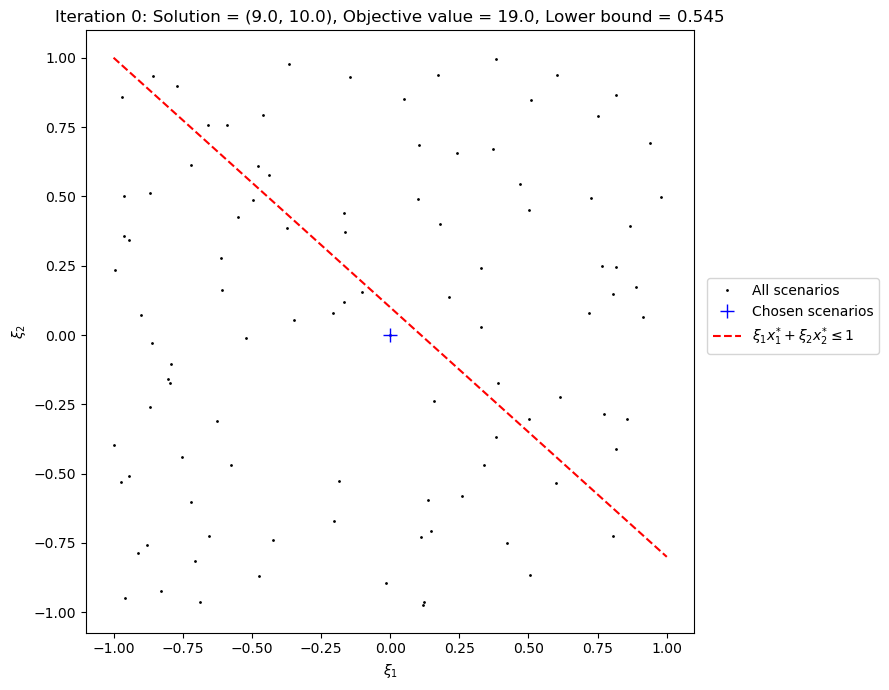

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


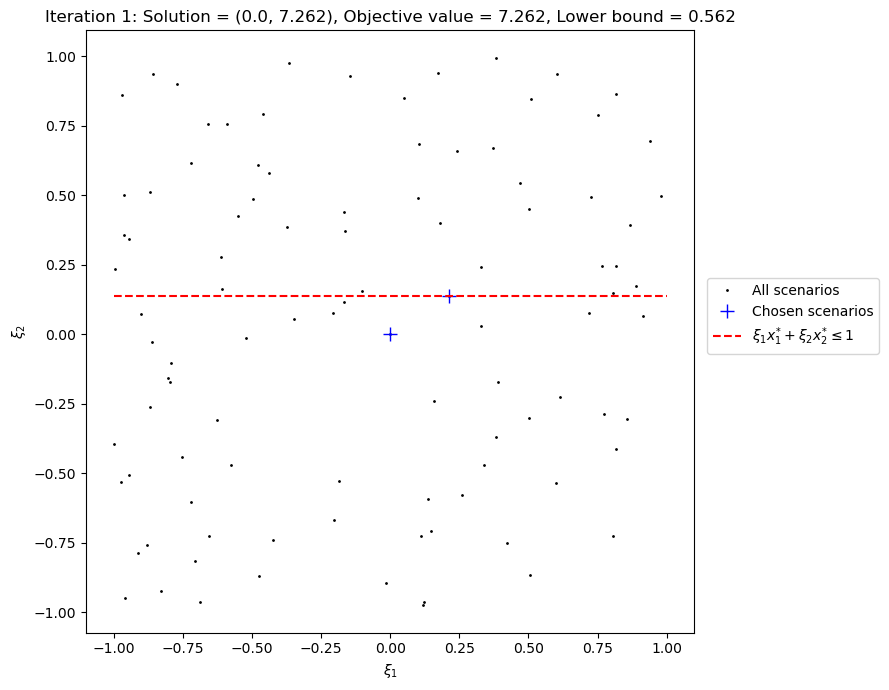

In [7]:
for i,sol in enumerate(solutions):
    if i<=1:
        Z_arr = data_train[sol['scenario_set']]
        dataio.plot_iter(i, data_train, Z_arr, sol['sol'], sol['obj'], sol['lb_test'],
                  True, "eps", True, N_train, alpha, beta)
    else:
        break

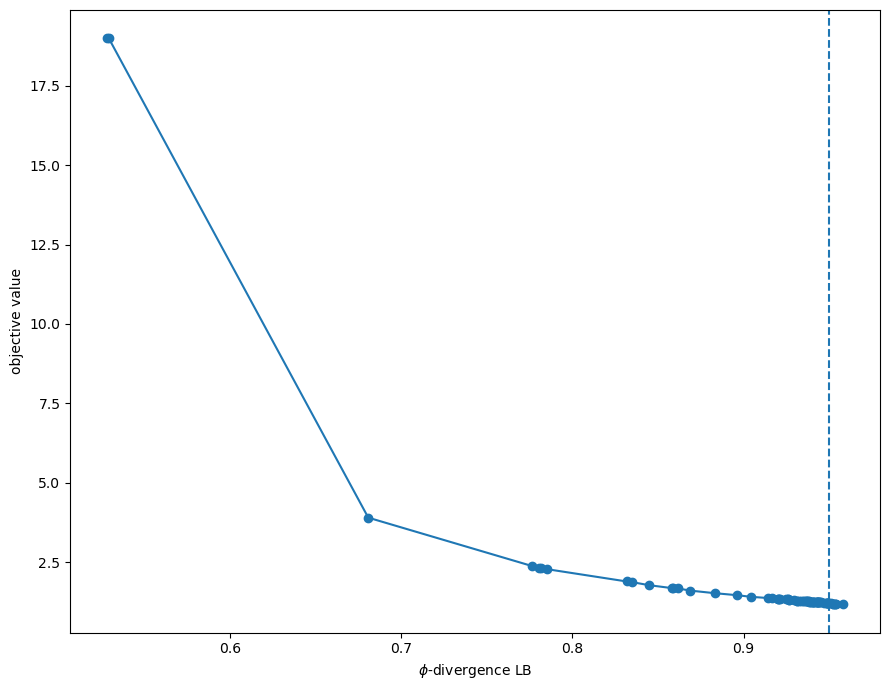

In [76]:
dataio.plot_pareto_curve(pareto_solutions, beta, None, None, None, None)

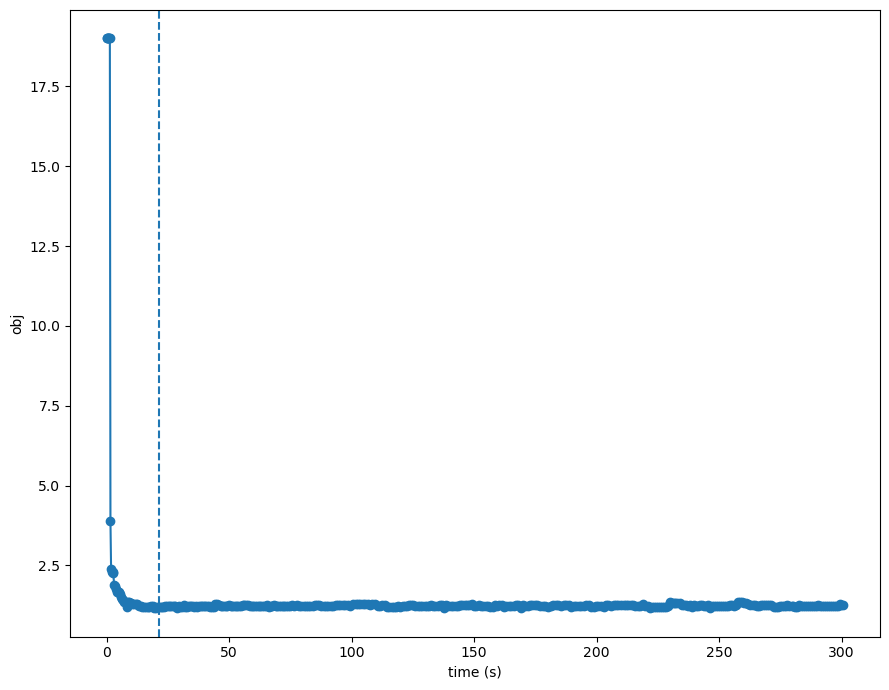

In [77]:
dataio.plot_obj_over_time(solutions, best_sol, None, None, None, None)

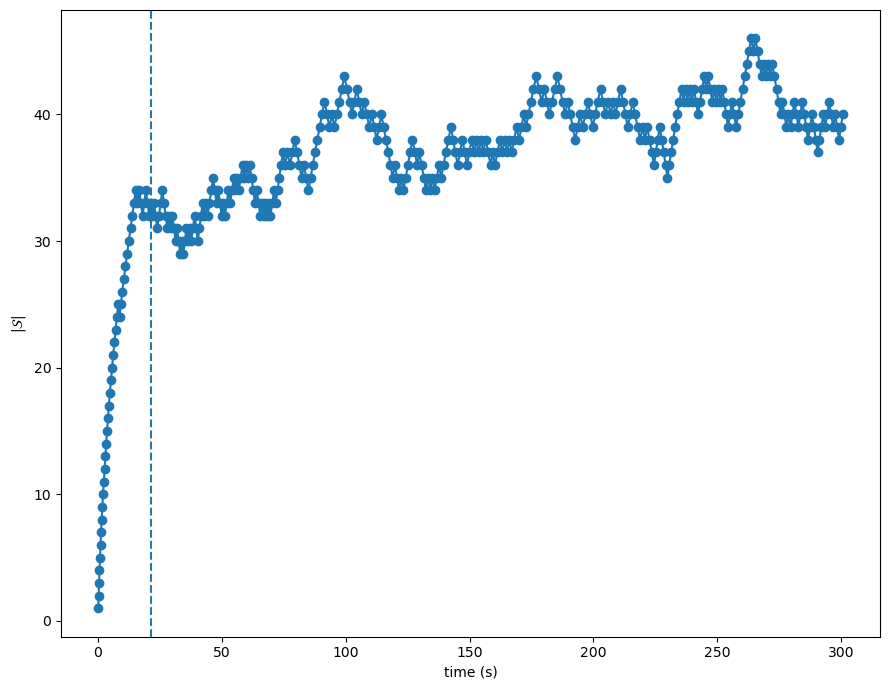

In [78]:
dataio.plot_size_set_over_time(solutions, best_sol, None, None, None, None)

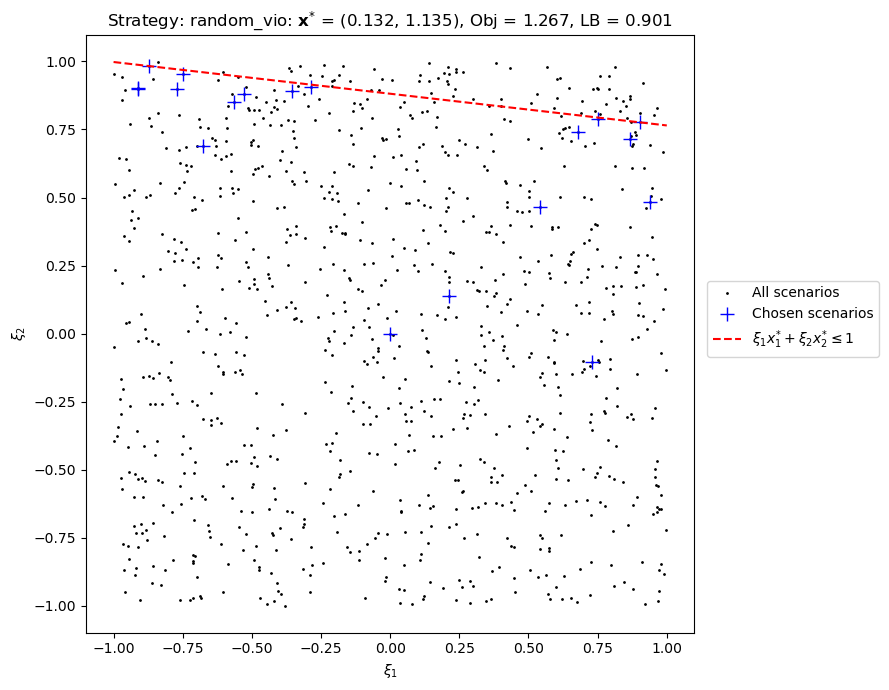

In [35]:
# Plot final solution found by algorithm
name = 'Strategy: '+ str(add_strategy)
save_plot = False
plot_type = "eps"
show_legend = True
Z_values = data_train[best_sol['scenario_set']]
dataio.plot_solution(name, data_train, Z_values, best_sol['sol'], 
              best_sol['obj'], best_sol['lb_test'], save_plot, plot_type, show_legend, N, alpha, beta)

In [126]:
# Compute optimal solution with true probability constraint
prob_true = beta
[x_true, obj_true] = solve_toyproblem_true_prob(prob_true, k)
constr = uncertain_constraint(data_test, x_true)
vio = constr[constr>(0+numeric_precision)]   
p_vio = len(vio)/N_train
p = np.array([1-p_vio, p_vio])
r = phi_dot/(2*N_test)*scipy.stats.chi2.ppf(1-alpha, 1)
lb = rs.compute_lb(p, r, par, phi_div)
print(p)
print(lb)
print(obj_true)

[0.895 0.105]
0.8614689962206747
1.5000000000066576


In [ ]:
name = "TrueProb="+str(prob_true)
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data_test, None, x_true, obj_true, lb, save_plot, plot_type, show_legend, N, alpha, beta)

In [10]:
# Determine optimal solution given data_test
runtime, opt_x, opt_sum_y, opt_obj, opt_lb = util.compute_opt_given_data(alpha, beta, par, phi_div, data_test, time_limit_mosek)

In [12]:
runtime

20.242980480194092

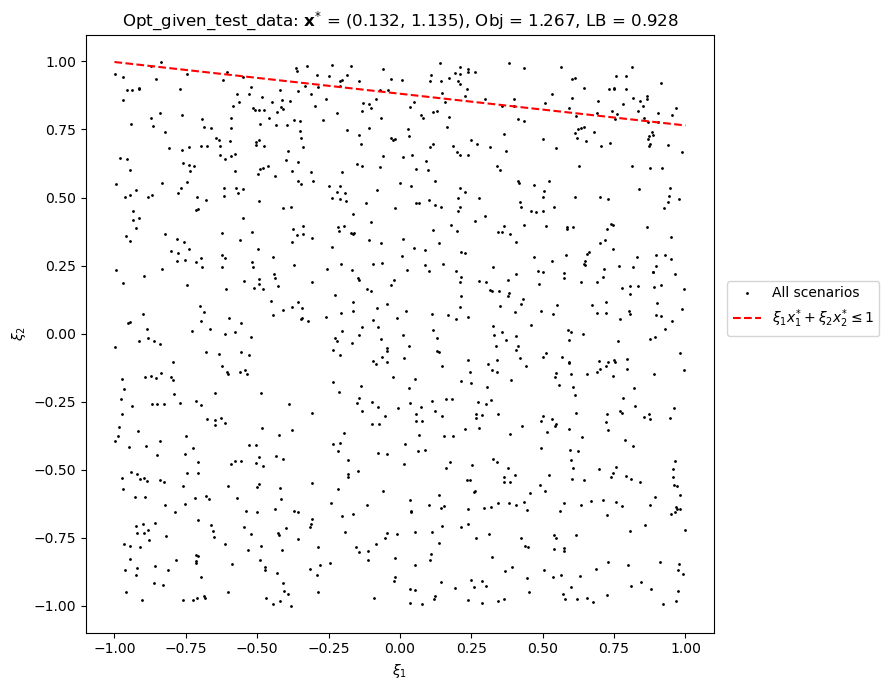

In [11]:
# Plot optimal solution given data_test
name = 'Opt_given_test_data'
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data_test, None, opt_x, opt_obj, opt_lb, save_plot, plot_type, show_legend, N, alpha, beta)

In [ ]:
# Compute solution via Campi method
data = generate_data(k, N_campi)
runtime, campi_x, campi_obj, campi_true_prob, Z_arr = util.solve_with_campi_N(alpha, beta, numeric_precision, data, time_limit_mosek)

In [ ]:
# Plot Campi solution
name = 'Campi method'
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data, Z_arr, campi_x, campi_obj, 0, save_plot, plot_type, show_legend, N, alpha, beta)

In [8]:
[i for i in range(1,10)]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

# The following cells are used to obtain output and write to latex tables

First we inspect the various strategies that could be employed

In [71]:
headers = ['k', 'seed', 
           'Obj.~(true prob.)', 'Obj.~Alg.', 'Gap (\%)', 'LB', 'True Prob.', 
           '\#Iter.~(add)', '\#Iter.~(remove)', '\#Iter.~(clean)', '$|\mathcal{X}|$',
           '$|\mathcal{S}_{best}|$', '$|\mathcal{S}_{max}|$', '$|\mathcal{S}_{avg}|$', 'Time until best found']

output_data = {}

# Variable parameter values
k_settings = [10000]#, 50000, 100000]
random_seed_settings = [i for i in range(1, 11)]

N_train = 1000
N_test = 10000
time_limit_search = 5*60

# Fixed parameter values
alpha = 10**-6
beta = 0.95
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 1
#time_limit_mosek = 5*60
time_limit_solve = 1*time_limit_search # in seconds 
max_nr_solutions = 5000 # for easy problems with long time limits, we may want extra restriction
numeric_precision = 1e-6 # To correct for floating-point math operations

# Alg settings
#add_strategy_settings = ['random_vio', 'random_weighted_vio'] 
#remove_strategy_settings = ['random_any', 'random_active']
add_strategy = 'random_vio' #['smallest_vio', 'N*(beta-lb)_smallest_vio', 'random_vio', 'random_weighted_vio']
remove_strategy = 'random_active' #'random_any'
clean_strategy = 'all_inactive'
clean_time_threshold = 0.05*time_limit_search
add_remove_threshold = 0.00 # should be fractional in relation to beta, set to 0 if not used

run_count = 0
for k in k_settings:
    
    x_true, obj_true = solve_toyproblem_true_prob(beta, k)
    
    for random_seed in random_seed_settings:

        data_train = generate_data_with_nominal(random_seed, k, N_train)
        data_test = generate_data(random_seed, k, N_test)
        
        runtime_search, num_iter, solutions = rs.search_alg(data_train, N_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                           max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                           add_remove_threshold, clean_time_threshold, 
                                                           par, phi_div, phi_dot, numeric_precision,
                                                           solve_SCP, uncertain_constraint, random_seed)

        runtime_eval, best_sol, pareto_solutions = rs.evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, phi_dot, 
                                                 uncertain_constraint, numeric_precision)
        obj_alg = best_sol['obj']
        time_best_found = best_sol['time']
        lb_alg = best_sol['lb_test']
        num_scen_best = len(best_sol['scenario_set'])

        # get num scen avg and max
        num_scen_avg = 0
        num_scen_max = 0
        for sol in solutions:
            num_scen = len(sol['scenario_set'])
            num_scen_avg += num_scen
            if num_scen > num_scen_max:
                num_scen_max = num_scen
        num_sol = len(solutions)
        num_scen_avg = num_scen_avg / num_sol

        x_true_prob = get_true_prob(best_sol['sol'], k)
        obj_gap_true =  100*(obj_true - obj_alg)/obj_true

        output_data[(k, random_seed)] = [f'{round(obj_true,3):.3f}',
                                         f'{round(obj_alg,3):.3f}',
                                              f'{round(obj_gap_true,1):.1f}',
                                              f'{round(lb_alg,3):.3f}',
                                              f'{round(x_true_prob,3):.3f}',
                                              num_iter['add'], 
                                              num_iter['remove'],
                                              num_iter['clean'],
                                              num_sol,
                                              num_scen_best,
                                              num_scen_max,
                                              f'{round(num_scen_avg,1):.1f}',
                                              f'{round(time_best_found, 0):.0f}']

        run_count += 1
        print("Completed run: " + str(run_count))

Completed run: 1
Completed run: 2
Completed run: 3
Completed run: 4
Completed run: 5
Completed run: 6
Completed run: 7
Completed run: 8
Completed run: 9
Completed run: 10


In [35]:
dataio.write_output_to_latex(2, headers, output_data)

\begin{table}[H]
\centering
\resizebox{\linewidth}{!}{\begin{tabular}{ll|rrrrrrrrrrrrr}
k & seed & Obj.~Alg. & Obj.~(true prob.) & Gap (\%) & LB & True Prob. & \#Iter.~(add) & \#Iter.~(remove) & \#Iter.~(clean) & $|\mathcal{X}|$ & $|\mathcal{S}_{best}|$ & $|\mathcal{S}_{max}|$ & $|\mathcal{S}_{avg}|$ & Time until best found\\
\hline
10 & 1 & 1.183 & 1.222 & 3.2 & 0.951 & 0.958 & 266 & 255 & 0 & 521 & 11 & 20 & 13.3 & 51 \\
10 & 2 & 1.198 & 1.222 & 2.0 & 0.951 & 0.955 & 299 & 283 & 0 & 582 & 13 & 21 & 15.2 & 9 \\
10 & 3 & 1.201 & 1.222 & 1.8 & 0.950 & 0.954 & 310 & 286 & 0 & 596 & 15 & 27 & 19.5 & 15 \\
10 & 4 & 1.191 & 1.222 & 2.5 & 0.950 & 0.956 & 303 & 287 & 0 & 590 & 15 & 22 & 16.7 & 47 \\
10 & 5 & 1.197 & 1.222 & 2.0 & 0.950 & 0.955 & 314 & 297 & 0 & 611 & 17 & 22 & 15.0 & 27 \\
10 & 6 & 1.203 & 1.222 & 1.6 & 0.950 & 0.954 & 243 & 226 & 0 & 469 & 18 & 24 & 18.7 & 20 \\
10 & 7 & 1.216 & 1.222 & 0.5 & 0.951 & 0.951 & 247 & 230 & 0 & 477 & 21 & 24 & 18.3 & 27 \\
10 & 8 & 1.204 & 1.222

In [72]:
output_file_name = 'new_output'

In [73]:
# Write output to .txt file
with open(r'output/'+output_file_name+'.txt','w+') as f:
    f.write(str(output_data))

In [19]:
# Read from .txt file
file_path = 'output/'+output_file_name+'.txt'
dic = ''
with open(file_path,'r') as f:
         for i in f.readlines():
            dic=i #string
output_data_read_2 = eval(dic)

In [74]:
import pandas as pd

output_data_agg = {}
for k in k_settings:
    df = pd.DataFrame({key: pd.Series(val) for key, val in output_data.items() if key[0] == k})
    df = df.astype(float)
    df_agg = df.agg(["mean","std"], axis="columns")
    records = df_agg.to_records(index=False)
    result = list(records)
    li = []
    for i, (mu,std) in enumerate(result):
        if i == 0:
            li.append(f'{round(mu,3):.3f}')
        elif i >= 5:
            li.append(f'{round(mu,1):.1f}' + " ("+f'{round(std,1):.1f}'+")")
        else:
            li.append(f'{round(mu,3):.3f}' + " ("+f'{round(std,3):.3f}'+")")
    output_data_agg[k] = li
output_data_agg

{10000: ['1.222',
  '1.202 (0.017)',
  '1.650 (1.405)',
  '0.950 (0.002)',
  '0.954 (0.004)',
  '210.0 (27.3)',
  '170.8 (34.6)',
  '0.0 (0.0)',
  '380.8 (61.7)',
  '37.3 (9.9)',
  '44.0 (8.4)',
  '35.2 (7.3)',
  '189.3 (88.1)']}

In [75]:
headers_agg = ['k',  
           'Obj.~(true prob.)', 'Obj.~Alg.', 'Gap (\%)', 'LB', 'True Prob.', 
           '\#Iter.~(add)', '\#Iter.~(remove)', '\#Iter.~(clean)', '$|\mathcal{X}|$',
           '$|\mathcal{S}_{best}|$', '$|\mathcal{S}_{max}|$', '$|\mathcal{S}_{avg}|$', 'Time until best found']
dataio.write_output_to_latex(1, headers_agg, output_data_agg)

\begin{table}[H]
\centering
\resizebox{\linewidth}{!}{\begin{tabular}{l|rrrrrrrrrrrrr}
k & Obj.~(true prob.) & Obj.~Alg. & Gap (\%) & LB & True Prob. & \#Iter.~(add) & \#Iter.~(remove) & \#Iter.~(clean) & $|\mathcal{X}|$ & $|\mathcal{S}_{best}|$ & $|\mathcal{S}_{max}|$ & $|\mathcal{S}_{avg}|$ & Time until best found\\
\hline
10000 & 1.222 & 1.202 (0.017) & 1.650 (1.405) & 0.950 (0.002) & 0.954 (0.004) & 210.0 (27.3) & 170.8 (34.6) & 0.0 (0.0) & 380.8 (61.7) & 37.3 (9.9) & 44.0 (8.4) & 35.2 (7.3) & 189.3 (88.1) \\
\end{tabular}}
\caption{}
\label{}
\end{table}


In [ ]:
# To plot histograms for random seed output
# Read from .txt file
output_file_name = 'new_output'
file_path = 'output/'+output_file_name+'.txt'
dic = ''
with open(file_path,'r') as f:
         for i in f.readlines():
            dic=i #string
output_data_read = eval(dic)

df = pd.DataFrame.from_dict(output_data_read, orient='index')
#li1 = [col for col in df.columns if 'add + improve' == col[1]]

df2 = pd.DataFrame({key: pd.Series(val) for key, val in output_data_read.items() if key[1] == 'add + improve + remove'})
obj2 = df2.iloc[0,:].astype(float)

title = 'Distribution of best found solution objective for random add + improve + remove'# for $\beta = 0.95$, $\alpha=10^{-6}$, $N_{1} = 1,000$, $N_{2} = 10,000$ and time limit $\mathcal{L} = 1$ minute'
dataio.plot_hist(obj2, 'Gap (%)', 'Frequency', title, 20, 0.75)